In [1]:
import requests
import json
from datetime import *
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd

import networkx as nx

import math
from statistics import mean 
from itertools import product

import subprocess
import pandas as pd

In [2]:
# Import my own library
# ToDo: Set userMax for optional ms to 0
import sys 
import os
path = os.path.dirname(os.getcwd())
sys.path.append(path)
from lib import *

# Baseline

In [7]:
data, vars_ms, userMax, energyDemand, q = getConstantsFromBPMN('../flightBooking.json')
# User Data
df = pd.read_csv(r'../data/projectcount_wikiDE_2015.csv')
clickData_hourly = df["De"].tolist()
clickData_hourly = clickData_hourly[24:] + clickData_hourly[0:24]

## Low Power

In [8]:
ed_hourly_lowPower = []
for i in range(8760):
    ed = 0
    s = clickData_hourly[i]
    for j in range(len(q)):
        if userMax[j][0] > 0:
            ed += energyDemand[j][0] * math.ceil(s / userMax[j][0])
        s = s * q[j][0]
    ed_hourly_lowPower.append(ed)

# Normal
Here the applications architecture was picked such that it's energy consumption lies in the middle of the spectrum. The architecture is not optimized for energy consumption, but also not for performance.

In [9]:
lowPower_ed = sum(energyDemand[i][0] for i in range(len(energyDemand)))
highPower_ed = sum(energyDemand[i][-1] for i in range(len(energyDemand)))

median_ed = (highPower_ed - lowPower_ed)/2


indices = []
for ms in data['components']:
    indices.append([0] * len(data['components'][ms]))

# Calculating all possible configurations
vars_gb = [[]]
for i in indices:
    vars_gb *= len(i)
ed_combo = list(product(*energyDemand))
userMax_combo = list(product(*userMax))
q_combo = list(product(*q))

for i in range(len(vars_gb)):
    vars_gb[i].append([ed_combo[i], userMax_combo[i], q_combo[i]])



In [10]:
# Finding the configuration with the closest energy demand to the median energy demand
temp = highPower_ed
for i in range(len(vars_gb)):
    if abs(sum(vars_gb[0][i][0])-median_ed) < temp:
        temp = abs(sum(vars_gb[0][i][0])-median_ed)
        index = i
normal_conf = vars_gb[0][index]

In [11]:
ed_hourly_normal = []
for i in range(8760):
    ed = 0
    s = clickData_hourly[i]
    for j in range(len(q)):
        if normal_conf[1][j] > 0:
            ed += normal_conf[0][j] * math.ceil(s / userMax[j][0])
        s = s * normal_conf[2][j]
    ed_hourly_normal.append(ed)

## High Performance

In [12]:
ed_hourly_highPower = []
for i in range(8760):
    ed = 0
    s = clickData_hourly[i]
    for j in range(len(q)):
        if userMax[j][-1] > 0:
            ed += energyDemand[j][-1] * math.ceil(s / userMax[j][-1])
        s = s * q[j][-1]
    ed_hourly_highPower.append(ed)

In [13]:
# new 03.07.23
df = pd.read_csv(r'../data/DE_2021.csv')
ci_data_2021_hourly = df['carbon_intensity_avg']

ed_daily_highPower = []
for i in range(365):
    temp = 0
    for j in range(24):
        temp += ed_hourly_highPower[i*24+j]*ci_data_2021_hourly[i*24+j]
    ed_daily_highPower.append(temp)

In [14]:
ed_hourly_lowPower = np.array(ed_hourly_lowPower)
#ed_hourly_highPower[1000] = 6277312.0
#ed_hourly_highPower[1001] = 6277312.0
ed_hourly_highPower = np.array(ed_hourly_highPower)

data = pd.DataFrame({'lp': ed_hourly_lowPower, 'hp': ed_hourly_highPower}, columns=['lp', 'hp'])

## Plots

[   0 1000 2000 3000 4000 5000 6000 7000 8000 8760]


Text(0.5, 1.0, 'Energy Demand for Low and High Power Microservice Deployment')

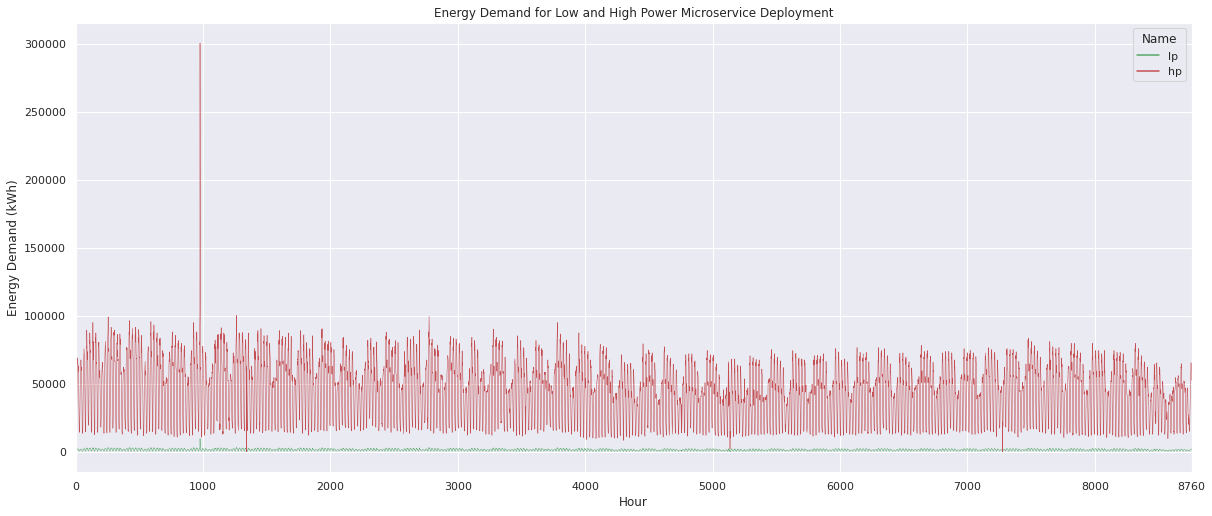

In [15]:
sns.set(rc={'figure.figsize':(20,8.27)})
#sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})


ax = sns.lineplot(data=pd.melt(data.reset_index(), id_vars="index",var_name="Name"), x='index',y="value",hue='Name', palette=['g', 'r'], linewidth=0.5)
plt.xticks([i*1000 for i in range (9)] + [8760])
print(plt.xticks()[0])
ax.set(xlabel='Hour', ylabel='Energy Demand (kWh)', xlim=(0,8760))

ax.set_title('Energy Demand for Low and High Power Microservice Deployment')

<AxesSubplot:>

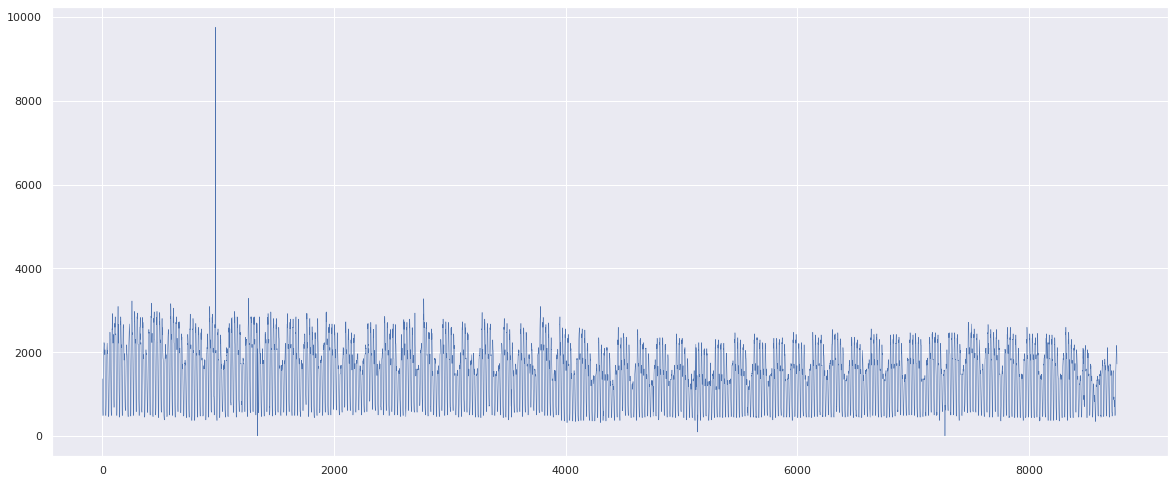

In [16]:
sns.lineplot(data=ed_hourly_lowPower, linewidth=0.5)

In [17]:
### Saving the plots to disk

In [18]:
fig = ax.get_figure()
fig.savefig("../img/baseline_edge-cases.png") 

# Write Data to CSV

In [20]:
f = open('../results/baseline.csv', 'a')
for lp,np,hp in zip(ed_hourly_lowPower,ed_hourly_normal,ed_hourly_highPower):
    row = []
    row.append(lp)
    row.append(np)
    row.append(hp)
    writer = csv.writer(f)
    writer.writerow(row)
f.close()